In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
import pandas as pd
from scipy import linalg as la
import math as ma

1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [2]:
#Creating the x array with the three distribution required
x=[]
x.append(np.random.randn(1000))
x=np.asarray(x)
x=np.append(x,[x[0,:]+3*np.random.randn(1000)],axis=0)
x=np.append(x,[2*x[0,:]+x[1,:]],axis=0)
#Finding eigenvalues with standard method
l, V = la.eig(np.cov(x))
#Finding eigenvalues using SVD
U, spec, Vt = np.linalg.svd(x)
l_svd = spec**2/(x.shape[1]-1)
V_svd = U
#Value check
print(l)
print(l_svd)
print(V)
print(V_svd)
#The principal component part is associated to the first row
print("Percentage of the total dataset associated to the principal part:",l[0]*100/np.diag(l).trace(),"%") 
#In the basis given by the PCA we have
xr = np.dot(V.T,x)
#To reduce dimensionality we have to erase the third dimension, the one with the lower eigenvalue, built as the sum of the other two.
xr_del=np.delete(xr,1,0)
l2,V2=la.eig(np.cov(xr_del))
print("The two new eigenvalues are:",l2)

[ 2.55185689e+01+0.j -2.16084469e-15+0.j  2.00241618e+00+0.j]
[2.55329340e+01 2.00313839e+00 6.53156152e-30]
[[-0.11871639 -0.81649658  0.56501305]
 [-0.57328045 -0.40824829 -0.71041035]
 [-0.81071323  0.40824829  0.41961576]]
[[-0.11879376  0.56499679 -0.81649658]
 [-0.57318316 -0.71048884 -0.40824829]
 [-0.81077068  0.41950474  0.40824829]]
Percentage of the total dataset associated to the principal part: (92.72403886316994+0j) %
The two new eigenvalues are: [25.51856889+0.j  2.00241618+0.j]


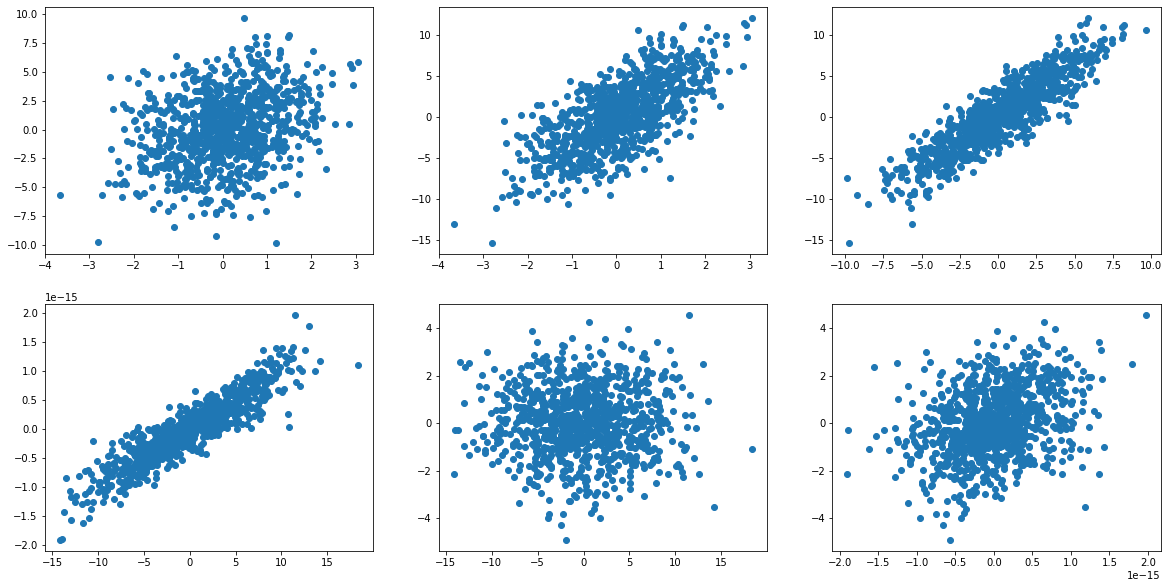

In [4]:
#Final plot
fig, ax=plt.subplots(2,3,figsize=(20,10))
for axes in ax: 
    for axe in axes:
        axe.xlim(-10,10)
        axe.ylim(-10,10)
ax[0,0].scatter(x[0,:],x[1,:])
ax[0,1].scatter(x[0,:],x[2,:])
ax[0,2].scatter(x[1,:],x[2,:])
ax[1,0].scatter(xr[0,:],xr[1,:])
ax[1,1].scatter(xr[0,:],xr[2,:])
ax[1,2].scatter(xr[1,:],xr[2,:])


2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [4]:
#Adding the 10 noise variables
x_noise=x
for i in range(10):
    x_noise=np.append(x_noise,[np.random.randn(1000)/50],axis=0)

In [5]:
#Calculating the eigenvectors and eigenvalues
l, V = la.eig(np.cov(x_noise))
print(l)
#A result similar to the previous, with the random noise becoming less important
xr_noise=np.dot(V.T,x_noise)
l2,V2=la.eig(np.cov(xr_noise))
print(l2)
#Again we have only two axes on which there is a significant distribution, referred to the third variable set  
#And to the noise variables. Cutting them we have
x_noisedel=np.delete(xr_noise,list(range(2,13)),0)
l3,V3=la.eig(np.cov(x_noisedel))
print(l3)
#Here we have the two most important dimensions

[ 2.66867967e+01+0.j  1.86656523e+00+0.j -3.80621671e-16+0.j
  4.64688389e-04+0.j  4.62484762e-04+0.j  3.29680489e-04+0.j
  4.20771322e-04+0.j  4.07509543e-04+0.j  3.99979341e-04+0.j
  3.62348287e-04+0.j  3.70727552e-04+0.j  3.74592630e-04+0.j
  3.73935701e-04+0.j]
[2.66867967e+01+0.j 1.86656523e+00+0.j 1.96838350e-18+0.j
 4.62484762e-04+0.j 4.64688389e-04+0.j 3.29680489e-04+0.j
 4.20771322e-04+0.j 4.07509543e-04+0.j 3.99979341e-04+0.j
 3.62348287e-04+0.j 3.70727552e-04+0.j 3.74592630e-04+0.j
 3.73935701e-04+0.j]
[26.68679667+0.j  1.86656523+0.j]


3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


In [28]:
#Creating the x array with a first row of spring movement, a second of noise and a third of zeros
#representing x,y,z axes
x=np.asarray(list(range(1000))).reshape(1,1000)
x=np.apply_along_axis(ma.cos,0,x)
x=np.append([x],[np.random.randn(1000)/15], axis=0)
x=np.append(x,[np.zeros(1000)],axis=0)

In [26]:
from scipy.spatial.transform import Rotation as R
cameras=[]
for i in range(5):
    theta = R.from_euler('x', np.random.uniform(0,360), degrees=True)
    phi   = R.from_euler('z', np.random.uniform(0,360), degrees=True)
    ang=theta*phi
    cameras.append(np.dot(x.T,ang.as_matrix()).T)

In [15]:
cameras=np.asarray(cameras).reshape(15,1000)
cameras.shape

(15, 1000)

In [16]:
L,V= la.eig(np.cov(cameras))
camrot=np.dot(V.T,cameras)

In [17]:
print(np.real_if_close(L))
#As expected after the rotation there is only one axis that gives information
#We can so drop the other dimension and concentrate only on the important one
camrot_del=np.delete(camrot,list(range(1,15)),0)

[ 2.50496561e+00  7.62348232e-17  2.18325130e-02 -2.54094784e-16
  1.90755483e-16  7.94989677e-17 -6.40647986e-17 -3.50659226e-17
  1.85101332e-17  1.85101332e-17 -2.62165460e-18  1.88925360e-18
  9.47291881e-19  6.06769540e-20 -5.60892264e-22]


/home/filippo/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Position')

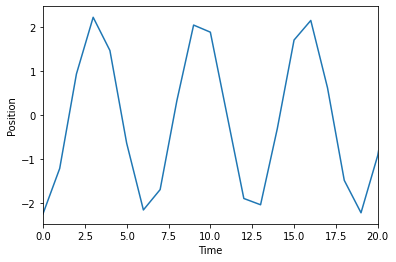

In [47]:
#As we can see the most important component is the cosinus
plt.plot(camrot_del[0])
plt.xlim(0,20)
plt.xlabel("Time")
plt.ylabel("Position")

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [12]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

--2020-11-24 23:26:59--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477391 (1,4M) [application/x-httpd-php]
Saving to: ‘/home/filippo/data/magic04.data.2’

magic04.data.2       14%[=>                  ] 216,00K  48,9KB/s    eta 25s    ^C
--2020-11-24 23:27:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5400 (5,3K) [application/x-httpd-php]
Saving to: ‘/home/filippo/data/magic04

In [33]:
#Creating the dataframe
df=pd.read_csv("/home/filippo/data/magic04.data", names=["fLength",
"fWidth",
"fSize",
"fConc", 
"fConc1",
"fAsym", 
"fM3Long",
"fM3Trans",
"fAlpha",
"fDist",
"class"])

In [34]:
#Replacing the last line with binary values for simplicity
df=df.replace({"class":{"g":1,"h":0}})

In [35]:
#Converting to array
arr=df.values.T

In [36]:
#Finding eigenvalues and eigenvectors
l,v=la.eig(np.cov(arr))

In [46]:
print(np.real_if_close(l)*100/np.real_if_close(l).sum())
#As we can see the last 4 values can be dropped to reduce dimension while preserving the main informations
print("The remaining info corresponds to about",np.real_if_close(l[0:7].sum())*100/np.real_if_close(l).sum(),"% of the total")

[4.40466498e+01 2.57987592e+01 1.34981328e+01 8.88172454e+00
 4.08498986e+00 2.90261107e+00 7.85438231e-01 1.04326075e-03
 5.77816391e-04 7.09203170e-05 2.57395320e-06]
The remaining info corresponds to about 99.9983054285885 % of the total


In [44]:
#We can again obtain the optimized dataset rotating the dataset and dropping the useless dimensions
magic=np.dot(v.T,arr)
magic_del=np.delete(magic,list(range(7,11)),0)